In [611]:
FILE_NAME = "farthest_trial/rc_2.csv"

In [612]:
import pandas as pd

df = pd.read_csv(FILE_NAME)

In [613]:
STEERING_ANGLE_COLUMN = 'Analog1|"V"|0.0|5.0|25'
TIME_COLUMN = 'Interval|"ms"|0|0|1'
REAR_AXLE_COLUMN =  'RPM2|"rpm"|0|8000|200'
YAW_COLUMN = 'Yaw|"Deg/Sec"|-120|120|200'
TIRE_RADIUS = 0.2921 # meters
TIRE_CIRCUMFERENCE = 2*TIRE_RADIUS * 3.14159 # meters


In [614]:

steering_angle = (df[STEERING_ANGLE_COLUMN]* (60.0/2.5)) - 60 # converting volts to degrees.
# It should be 0 volts = 60 degrees left
# 1.4 volts = 60 degrees right
times = df[TIME_COLUMN]

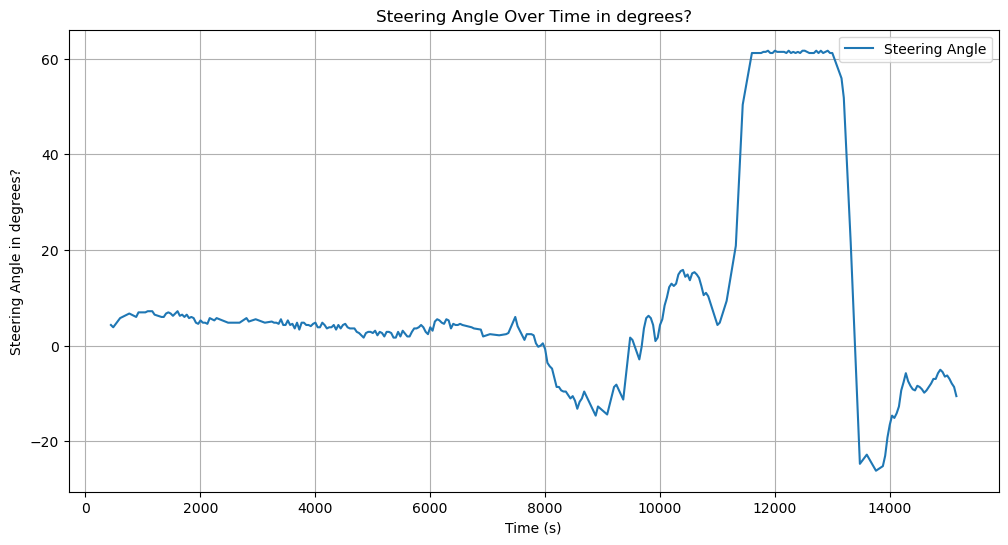

In [615]:
import matplotlib.pyplot as plt

valid_mask = ~steering_angle.isna()

plt.figure(figsize=(12, 6))
plt.plot(times[valid_mask], steering_angle[valid_mask], label='Steering Angle')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle in degrees?')
plt.title('Steering Angle Over Time in degrees?')
plt.legend()
plt.grid()
plt.show()


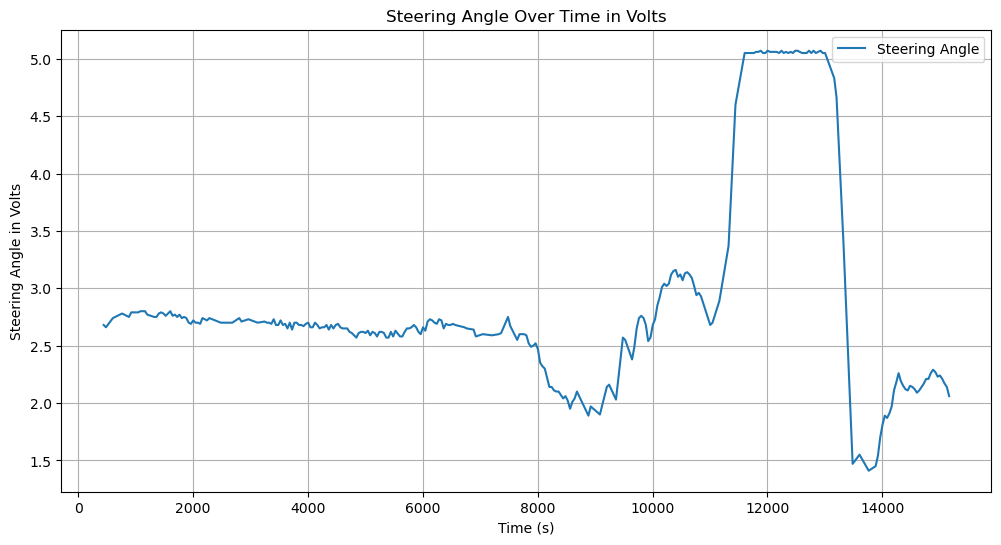

In [616]:
import matplotlib.pyplot as plt

valid_mask = ~df[STEERING_ANGLE_COLUMN].isna()

plt.figure(figsize=(12, 6))
plt.plot(times[valid_mask], df[STEERING_ANGLE_COLUMN][valid_mask], label='Steering Angle')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle in Volts')
plt.title('Steering Angle Over Time in Volts')
plt.legend()
plt.grid()
plt.show()


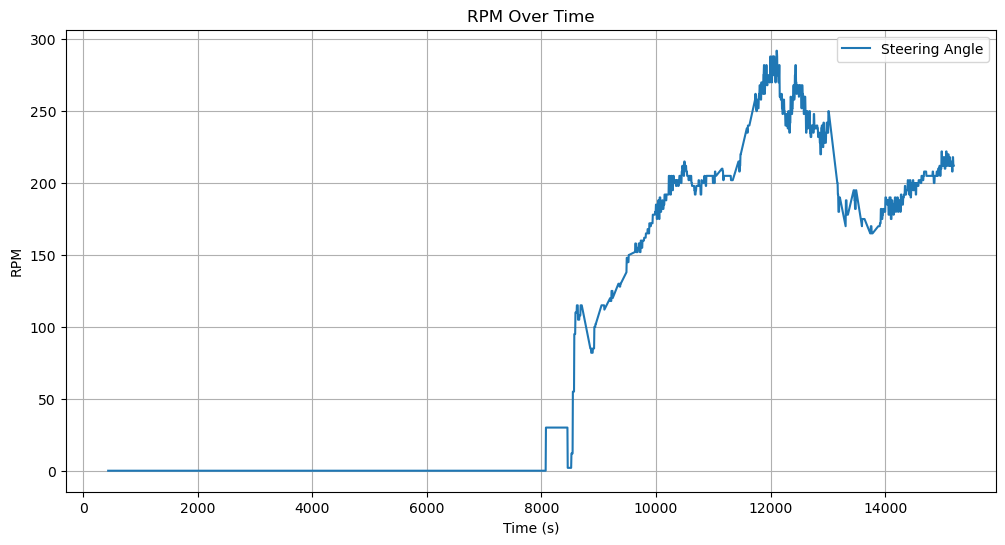

In [617]:
import matplotlib.pyplot as plt

valid_mask = ~df[REAR_AXLE_COLUMN].isna()

plt.figure(figsize=(12, 6))
plt.plot(times[valid_mask], df[REAR_AXLE_COLUMN][valid_mask], label='Steering Angle')
plt.xlabel('Time (s)')
plt.ylabel('RPM')
plt.title('RPM Over Time')
plt.legend()
plt.grid()
plt.show()


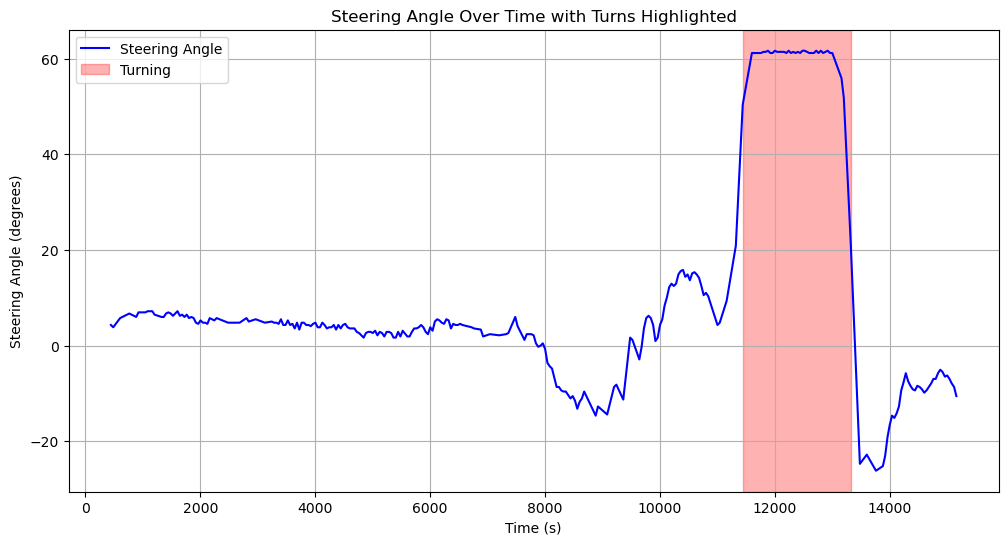

Detected turning intervals (original indices):
Start Index: 1660, End Index: 1949


In [618]:
import numpy as np
import matplotlib.pyplot as plt

# Remove NaNs
valid_mask = ~steering_angle.isna()
valid_indices = np.where(valid_mask)[0]  # Mapping from clean to original
times_clean = times[valid_mask].reset_index(drop=True)
steering_angle_clean = steering_angle[valid_mask].reset_index(drop=True)

# Settings
STEERING_THRESHOLD = 32   # degrees threshold
DELTA_THRESHOLD = 8       # degrees per second threshold

# Compute steering change per second
dt = np.diff(times_clean)              
dsteer = np.diff(steering_angle_clean)  
steer_rate = dsteer / dt                

# Detect conditions
is_turning = np.abs(steering_angle_clean) > STEERING_THRESHOLD
is_changing = np.abs(steer_rate) > DELTA_THRESHOLD

# Pad to match array length
is_changing = np.append(is_changing, False)

# Find intervals
def find_intervals(mask):
    intervals = []
    in_interval = False
    start_index = None

    for i, val in enumerate(mask):
        if val and not in_interval:
            start_index = i
            in_interval = True
        elif not val and in_interval:
            end_index = i
            intervals.append((start_index, end_index))
            in_interval = False

    if in_interval:
        intervals.append((start_index, len(mask)-1))
    
    return intervals

turning_intervals_clean = find_intervals(is_turning)

# Map intervals back to original indices
turning_intervals_original = [(valid_indices[start], valid_indices[end]) for (start, end) in turning_intervals_clean]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(times_clean, steering_angle_clean, label='Steering Angle', color='blue')

# Highlight turning regions
for start_idx, end_idx in turning_intervals_clean:
    plt.axvspan(times_clean[start_idx], times_clean[end_idx], color='red', alpha=0.3, label='Turning' if start_idx == turning_intervals_clean[0][0] else "")

plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (degrees)')
plt.title('Steering Angle Over Time with Turns Highlighted')
plt.legend()
plt.grid()
plt.show()

# Print intervals
print("Detected turning intervals (original indices):")
for start, end in turning_intervals_original:
    print(f"Start Index: {start}, End Index: {end}")


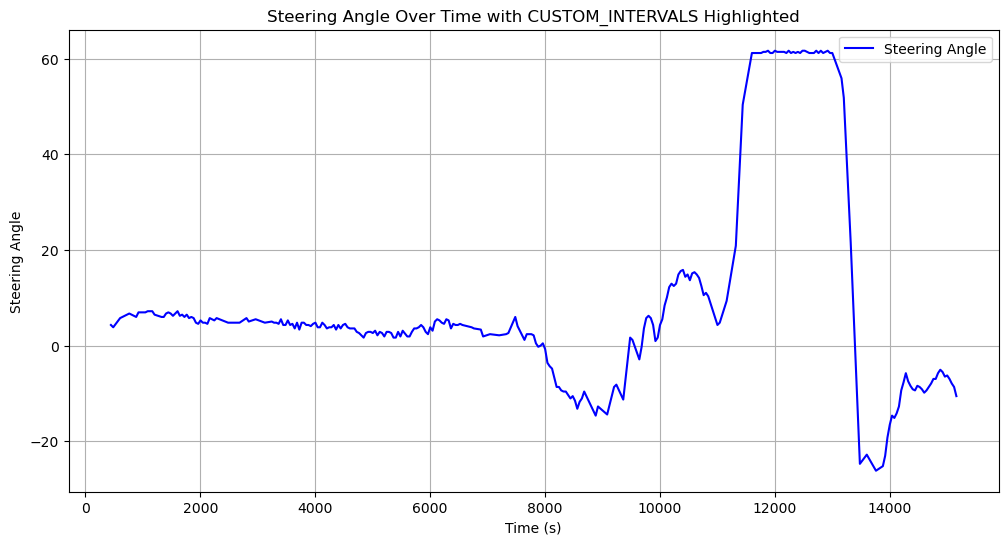

In [619]:
CUSTOM_INTERVALS = []

# Plotting the custom intervals graph
plt.figure(figsize=(12, 6))
plt.plot(times_clean, steering_angle_clean, label='Steering Angle', color='blue')

# Highlight custom intervals with vertical lines
for start, end in CUSTOM_INTERVALS:
    plt.axvline(x=times_clean[start], color='green', linestyle='--', label=f'Interval Start: {start}' if start == CUSTOM_INTERVALS[0][0] else "")
    plt.axvline(x=times_clean[end], color='green', linestyle='--', label=f'Interval End: {end}' if end == CUSTOM_INTERVALS[-1][1] else "")

plt.xlabel('Time (s)')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Over Time with CUSTOM_INTERVALS Highlighted')
plt.legend()
plt.grid()
plt.show()

In [620]:
def check_turning_radius(turning_interval, rear_axle, steering_angle, yaw, wheel_circumference):
    start, end = turning_interval
    radii = []

    for i in range(start, end + 1):
        rpm = rear_axle.iloc[i]
        steer = steering_angle.iloc[i]
        yaw_rate = yaw.iloc[i]


        if np.isnan(steer) or np.isnan(yaw_rate):
            continue

        
        # Compute linear velocity (in m/s)
        velocity = wheel_circumference * rpm * np.sin(np.radians(steer)) / 60.0
        
        #print(f"Wheel Circumference: {wheel_circumference} m, RPM: {rpm}, Steering Angle: {steer} degrees")
        
        #print(f"Velocity: {velocity} m/s, Yaw Rate: {yaw_rate} rad/s")
        
        # Avoid division by zero if yaw rate is 0
        if yaw_rate == 0:
            continue
        
        
        ################### UP TO HERE SEEMS TO BE CORRECT ###################
        #### DOWN HERE SEEMS TO BE INCORRECT #### 

        # Compute turning radius (in meters)
        radius = velocity / yaw_rate 
        radii.append(radius)

    # Compute median radius because mean seems sensitive to outliers
    avg_radius = np.median(radii) if radii else np.nan
    


    return radii, avg_radius

In [621]:
print("Turning intervals:", turning_intervals_original[0])
#constant_array =  pd.Series(np.full(len(df), 18))
#constant_array2 =  pd.Series(np.full(len(df), 180))

steering_angle_complement = 90 - abs(steering_angle)

radii_list, avg_radius = check_turning_radius(
    turning_interval=turning_intervals_original[0],  # Use the first detected turning interval
    #rear_axle=constant_array2,
    #steering_angle=constant_array,
    rear_axle=df[REAR_AXLE_COLUMN],
    steering_angle=steering_angle_complement,
    yaw= np.deg2rad(df[YAW_COLUMN]),
    wheel_circumference=TIRE_CIRCUMFERENCE
)

print("All Radii:", radii_list)
print("Average Radius:", avg_radius)



Turning intervals: (1660, 1949)
All Radii: [21.835172115986644, 4.503044139001675, 3.3005266700637272, 2.966548766347531, 2.7256343397233365, 2.5210948410035963, 2.3809845884971352, 2.2325789751660947, 2.117054129191849, 2.1937226685773275, 2.114277104645205, 2.1944481059677305, 2.1569192904741326, 2.2634982507215864, 2.309513595482018, 2.463430028983269, 2.5666709492584596, 2.9840378112904933, 3.0344849976379327, 2.746585657071804, 2.3454933862326848, 2.122113063734334, 1.9256544623659413, 1.8293616814694305, 1.7301655247188814, 1.675239635045266, 1.5963357971971706, 1.6609589037301262, 1.6628497887470528, 1.7558883395996574, 1.829499855484023, 1.8804189199849848, 1.816086197569072, 1.803776203406921, 1.4879824662184724, 1.7289358841787035, 3.6909720462646876]
Average Radius: 2.1937226685773275


In [624]:
print("Furthest")
print(np.mean(pd.read_csv('farthest_trial/rc_0.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('farthest_trial/rc_1.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('farthest_trial/rc_2.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('farthest_trial/rc_3.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('farthest_trial/rc_4.csv')[REAR_AXLE_COLUMN]))

print("middle")
print(np.mean(pd.read_csv('middle_trial/rc_4.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('middle_trial/rc_5.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('middle_trial/rc_6.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('middle_trial/rc_7.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('middle_trial/rc_8.csv')[REAR_AXLE_COLUMN]))

print("closest")
print(np.mean(pd.read_csv('nearest_trial/rc_0.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('nearest_trial/rc_1.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('nearest_trial/rc_3.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('nearest_trial/rc_5.csv')[REAR_AXLE_COLUMN]))
print(np.mean(pd.read_csv('nearest_trial/rc_6.csv')[REAR_AXLE_COLUMN]))


Furthest
55.88215931533904
76.58410985777341
87.81085892300845
85.35135135135135
72.80115916183682
middle
76.56281618887016
99.61572052401746
74.94332887103971
80.74693477194704
88.00243309002433
closest
73.41078355314197
78.74468085106383
89.32883490778228
118.26419120785317
94.35136343316942
